<a href="https://colab.research.google.com/github/Shreya549/Stonks/blob/main/Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing pmdarima**

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.6MB/s 
     |████████████████████████████████| 8.7MB 8.7MB/s 
     |████████████████████████████████| 808kB 19.3MB/s 
     |████████████████████████████████| 2.1MB 17.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


**Importing the libraries**

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

**Reading the dataset**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Shreya549/Stonks/main/RELIANCE.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


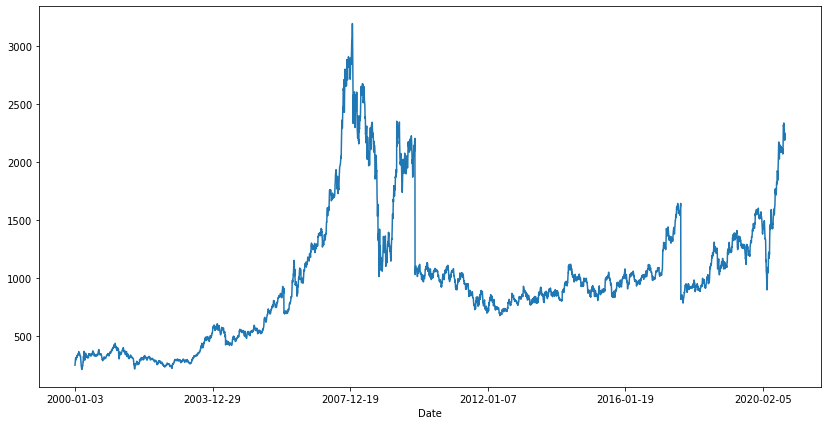

In [ ]:
df.VWAP.plot(figsize=(14, 7))

In [ ]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,133282.656291,2.216833e+06,0.437587,997.865723,997.102478,992.760376,13.807308,22.042711,47.256947,968.536682,967.787903,963.542603,13.879977,22.097956,47.113804,5384612.0,5383993.0,5374074.5,1.619044e+06,1.984213e+06,2485396.25,5.530794e+14,5.520444e+14,5.438880e+14,1.631049e+14,2.010406e+14,2.494978e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,133282.656291,2.216833e+06,0.437587,251.699997,251.699997,251.699997,13.807308,22.042711,47.256947,237.500000,237.500000,237.500000,13.879977,22.097956,47.113804,4456424.0,4456424.0,4456424.0,1.619044e+06,1.984213e+06,2485396.25,1.111319e+14,1.111319e+14,1.111319e+14,1.631049e+14,2.010406e+14,2.494978e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,133282.656291,2.216833e+06,0.437587,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,244.399994,244.399994,244.399994,9.758074,9.758074,9.758074,6972151.0,6972151.0,6972151.0,3.557775e+06,3.557775e+06,3557775.25,1.805771e+14,1.805771e+14,1.805771e+14,9.821026e+13,9.821026e+13,9.821026e+13,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,133282.656291,2.216833e+06,0.437587,270.483337,270.483337,270.483337,18.138657,18.138657,18.138657,248.483337,248.483337,248.483337,9.880832,9.880832,9.880832,13592662.0,13592662.0,13592662.0,1.173978e+07,1.173978e+07,11739778.00,3.661746e+14,3.661746e+14,3.661746e+14,3.288799e+14,3.288799e+14,3.288799e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,133282.656291,2.216833e+06,0.437587,286.816681,278.037506,278.037506,14.455478,21.156614,21.156614,265.649994,258.612488,258.612488,20.397856,21.805672,21.805672,17334616.0,14115068.0,14115068.0,8.790159e+06,9.642262e+06,9642262.00,4.835724e+14,3.904623e+14,3.904623e+14,2.443038e+14,2.728875e+14,2.728875e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594


In [ ]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,133282.656291,2.216833e+06,0.437587,997.865723,997.102478,992.760376,13.807308,22.042711,47.256947,968.536682,967.787903,963.542603,13.879977,22.097956,47.113804,5384612.0,5383993.0,5374074.5,1.619044e+06,1.984213e+06,2485396.25,5.530794e+14,5.520444e+14,5.438880e+14,1.631049e+14,2.010406e+14,2.494978e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594,1,1,3,0
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,133282.656291,2.216833e+06,0.437587,251.699997,251.699997,251.699997,13.807308,22.042711,47.256947,237.500000,237.500000,237.500000,13.879977,22.097956,47.113804,4456424.0,4456424.0,4456424.0,1.619044e+06,1.984213e+06,2485396.25,1.111319e+14,1.111319e+14,1.111319e+14,1.631049e+14,2.010406e+14,2.494978e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594,1,1,4,1
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,133282.656291,2.216833e+06,0.437587,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,244.399994,244.399994,244.399994,9.758074,9.758074,9.758074,6972151.0,6972151.0,6972151.0,3.557775e+06,3.557775e+06,3557775.25,1.805771e+14,1.805771e+14,1.805771e+14,9.821026e+13,9.821026e+13,9.821026e+13,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594,1,1,5,2
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,133282.656291,2.216833e+06,0.437587,270.483337,270.483337,270.483337,18.138657,18.138657,18.138657,248.483337,248.483337,248.483337,9.880832,9.880832,9.880832,13592662.0,13592662.0,13592662.0,1.173978e+07,1.173978e+07,11739778.00,3.661746e+14,3.661746e+14,3.661746e+14,3.288799e+14,3.288799e+14,3.288799e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594,1,1,6,3
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,133282.656291,2.216833e+06,0.437587,286.816681,278.037506,278.037506,14.455478,21.156614,21.156614,265.649994,258.612488,258.612488,20.397856,21.805672,21.805672,17334616.0,14115068.0,14115068.0,8.790159e+06,9.642262e+06,9642262.00,4.835724e+14,3.904623e+14,3.904623e+14,2.443038e+14,2.728875e+14,2.728875e+14,133156.734375,132951.1875,131483.015625,33587.8125,40901.25,49505.308594,1,1,7,4


In [ ]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [ ]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=46940.981, Time=18.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=48402.489, Time=14.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=47214.277, Time=14.42 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47277.258, Time=15.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=83686.779, Time=13.82 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=47071.820, Time=18.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46947.510, Time=16.40 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=46943.362, Time=18.45 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=46943.615, Time=18.75 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47075.563, Time=15.76 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=46982.927, Time=18.24 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=46955.504, Time=18.00 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=46946.168, Time=19.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=46938.800, Time=17.55 sec
 ARIM

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import pickle
filename = 'arimax_model.sav'
pickle.dump(model, open(filename, 'wb'))

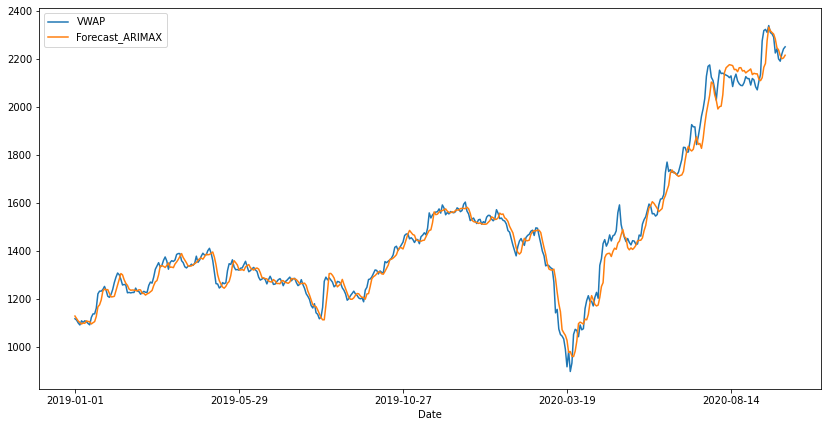

In [ ]:
#The best ARIMA model is ARIMA(2, 0, 2) which has the lowest AIC.
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 44.767735558407566

MAE of Auto ARIMAX: 31.20870483009516


In [ ]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



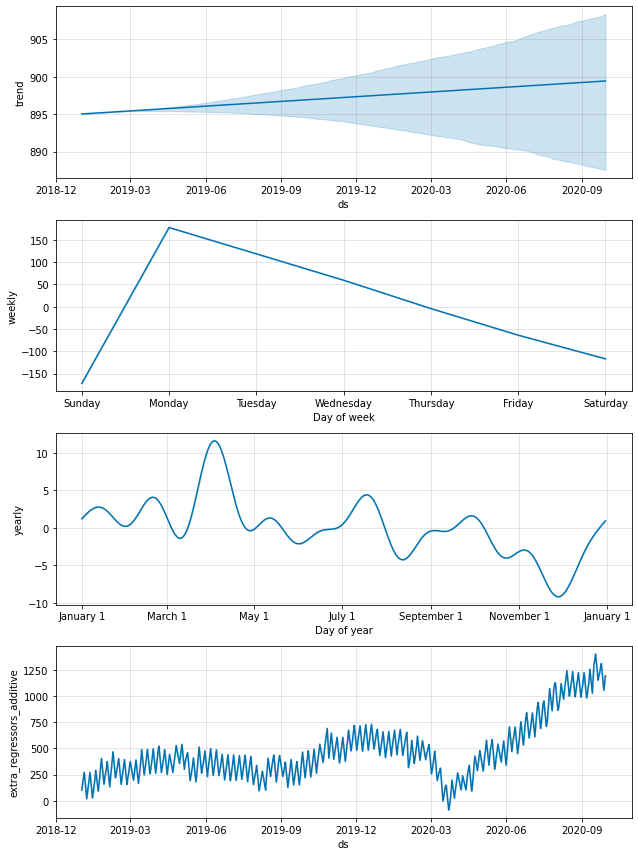

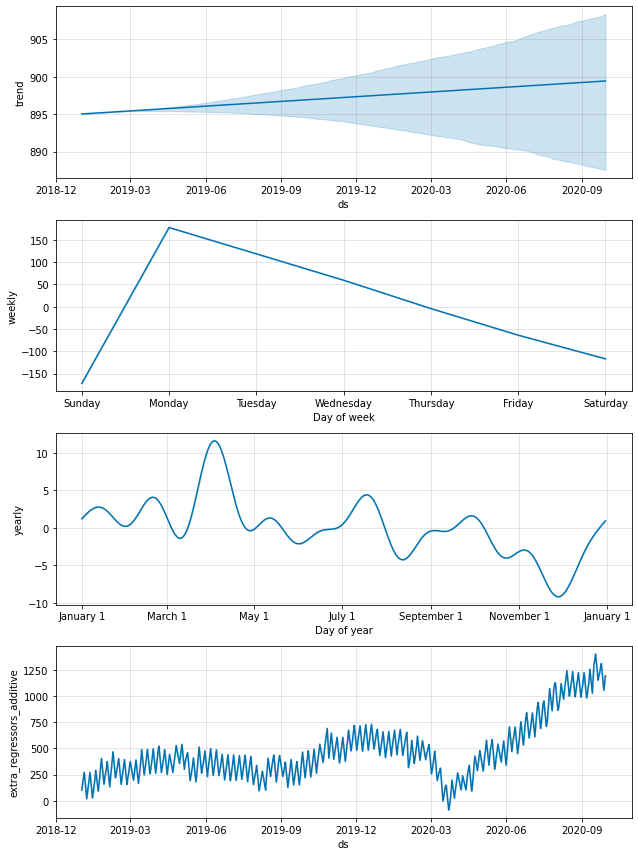

In [ ]:
model_fbp.plot_components(forecast)

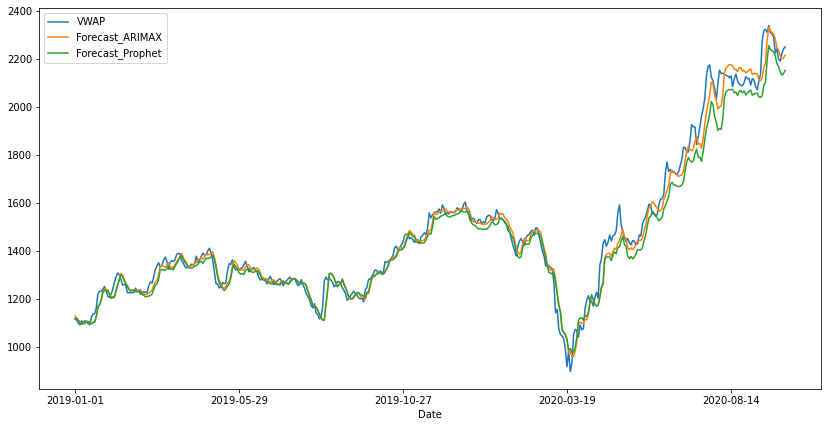

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX","Forecast_Prophet"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 44.767735558407566
RMSE of Prophet: 60.93832392507852

MAE of Auto ARIMAX: 31.20870483009516
MAE of Prophet: 42.132776834815864


In [ ]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



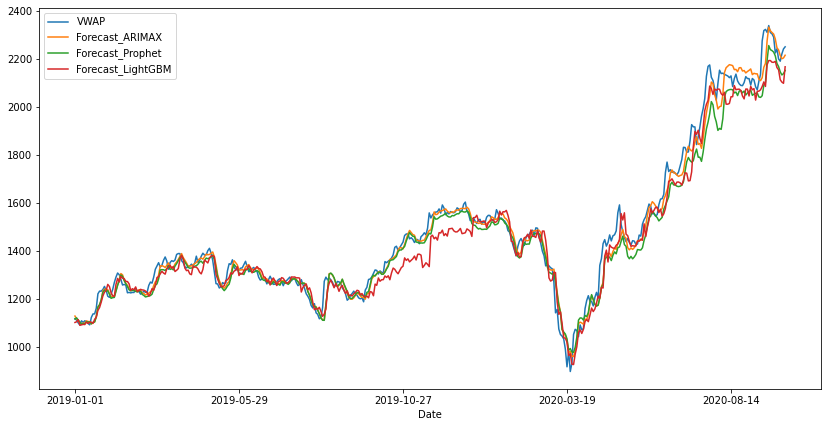

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX","Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))
print("MAE of LightGBM:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM))

RMSE of Auto ARIMAX: 44.767735558407566
RMSE of Prophet: 60.93832392507852
RMSE of LightGBM: 63.877830977039146

MAE of Auto ARIMAX: 31.20870483009516
MAE of Prophet: 42.132776834815864
MAE of LightGBM: 48.27872617233093


In [ ]:
#Getting libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['VWAP'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=3, epochs=15)

Epoch 1/15
1357/1357 [==============================] - 34s 25ms/step - loss: 0.0012
Epoch 2/15
1357/1357 [==============================] - 34s 25ms/step - loss: 4.4233e-04
Epoch 3/15
1357/1357 [==============================] - 34s 25ms/step - loss: 3.8595e-04
Epoch 4/15
1357/1357 [==============================] - 35s 26ms/step - loss: 2.1782e-04
Epoch 5/15
1357/1357 [==============================] - 35s 26ms/step - loss: 1.9708e-04
Epoch 6/15
1357/1357 [==============================] - 35s 26ms/step - loss: 2.1058e-04
Epoch 7/15
1357/1357 [==============================] - 35s 26ms/step - loss: 2.0695e-04
Epoch 8/15
1357/1357 [==============================] - 35s 26ms/step - loss: 2.0017e-04
Epoch 9/15
1357/1357 [==============================] - 36s 27ms/step - loss: 1.7401e-04
Epoch 10/15
1357/1357 [==============================] - 35s 26ms/step - loss: 2.1149e-04
Epoch 11/15
1357/1357 [==============================] - 36s 26ms/step - loss: 1.7724e-04
Epoch 12/15
1357/1357 [

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

36.25469559985088

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("RMSE of LSTM:", rmse)

RMSE of Auto ARIMAX: 44.767735558407566
RMSE of Prophet: 60.93832392507852
RMSE of LightGBM: 63.877830977039146
RMSE of LSTM: 36.25469559985088


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I

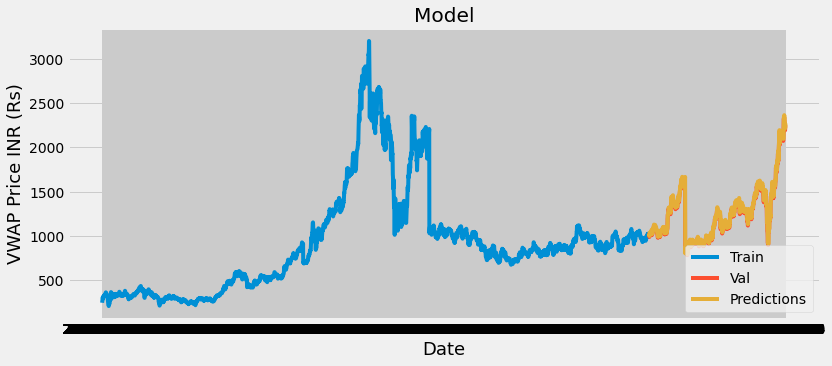

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(12,5))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('VWAP Price INR (Rs)', fontsize=18)
plt.plot(train['VWAP'])
plt.plot(valid[['VWAP', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()